In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
import astropy.io.fits as fits
from astropy import units as u
from collections import defaultdict

In [2]:
import DPConCFil
from DPConCFil.Clump_Class import *
from DPConCFil.Filament_Class import *
import DPConCFil.Plot_and_Save_Funs as Plot_and_Save_Funs
import DPConCFil.Profile_Funs as Profile_Funs

## The reference of the Example data 

'Example_Filaments_13CO_1.fits' is the $^{13}CO$ ($J = 1-0$) emission line of the Milky Way Imaging Scroll Painting (MWISP) within $17.7^{\circ} \leq l \leq 18.5^{\circ}$, $0^{\circ} \leq b \leq 0.8^{\circ}$ and 5 km s$^{-1}$ $\leq v \leq$ 30 km s$^{-1}$. 

MWISP project is a multi-line survey in $^{12}CO$/$^{13}CO$/$C^{18}O$ along the northern galactic plane with PMO-13.7m telescope.

In [3]:
file_example = 'Example_Filaments_13CO_1'
file_name = "../Example_Files/Data/{}.fits".format(file_example)

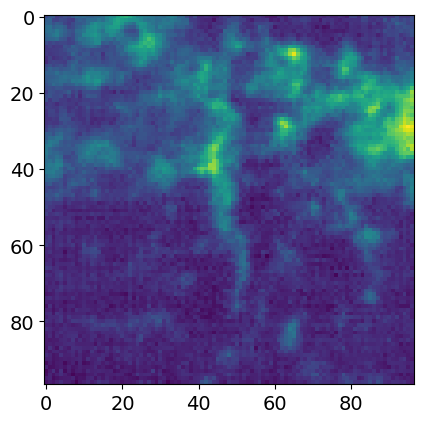

In [4]:
real_data = fits.getdata(file_name)
plt.imshow(real_data.sum(0))
plt.show()

## Calculate the clump information

The parameters of FacetClumps. Please see the introduction of [FacetClumps](https://github.com/JiangYuTS/FacetClumps/blob/master/Examples/Examples_Files_FacetClumps.ipynb) for more details.

In [5]:
SWindow = 3 # [3,5,7]
KBins = 35 # [10,...,60]
FwhmBeam = 2
VeloRes = 2
SRecursionLBV = [9, 4] # [(2+FwhmBeam)**2,3+VeloRes]

header = fits.getheader(file_name)
RMS = header['RMS']
Threshold = 5 * RMS

parameters_FacetClumps = [RMS, Threshold, SWindow, KBins, FwhmBeam, VeloRes, SRecursionLBV]

Construct clump objects. These file names are necessary parameters.

**file_name**: File name.

**mask_name**: Mask name, the file use to store the region information or store the region information. 

**outcat_name**: The file used to store clump table in pixel coordinate system.

**outcat_wcs_name**: The file used to store clump table in WCS coordinate system.

In [6]:
mask_name = 'Example_Files/Clump/mask_{}.fits'.format(file_example)
outcat_name = 'Example_Files/Clump/outcat_{}.csv'.format(file_example)
outcat_wcs_name = 'Example_Files/Clump/outcat_wcs_{}.csv'.format(file_example)

In [7]:
clumpsObj = ClumpInfor(file_name,mask_name,outcat_name,outcat_wcs_name)

### Calculate the clump information from FacetClumps. 

In this case, the parameters of FacetClumps is essential. More clump detection algorithms can also be added to this process. 

The angle of the clumps detected by FacetClumps is obtained by diagonalizing the moment of inertia matrix, please the article of [FacetClumps](https://iopscience.iop.org/article/10.3847/1538-4365/acda89) for more details. Performing a two-dimensional single Gaussian fitting on the velocity integrated map of a clump can provide more accurate position and direction information of the clump in spatial direction. 

When 'fit_flag=True', it indicates that the fitting will be used. This will benefit the performance of DPConFil.

In [8]:
clumpsObj.Cal_Infor_From_Mask_Or_Algorithm(mask_or_algorithm='FacetClumps',parameters=parameters_FacetClumps)
clumpsObj.Get_Clumps_Infor(fit_flag = True)

100%|██████████| 39/39 [00:00<00:00, 178.60it/s]


Number: 126
Time: 10.68


100%|██████████| 126/126 [00:01<00:00, 71.56it/s]

Fitting Clumps Time: 1.77


### Calculate the clump information from the mask file 'mask_name'. 

The mask is the region information of clumps, which can be obtained by any clump detection algorithm.

In [9]:
clumpsObj.Cal_Infor_From_Mask_Or_Algorithm(mask_or_algorithm='mask')
clumpsObj.Get_Clumps_Infor(fit_flag = True)

Number: 126
Time: 0.07


100%|██████████| 126/126 [00:01<00:00, 72.07it/s]

Fitting Clumps Time: 1.76


Plot the original image. If save_path=None, the image will not be saved.

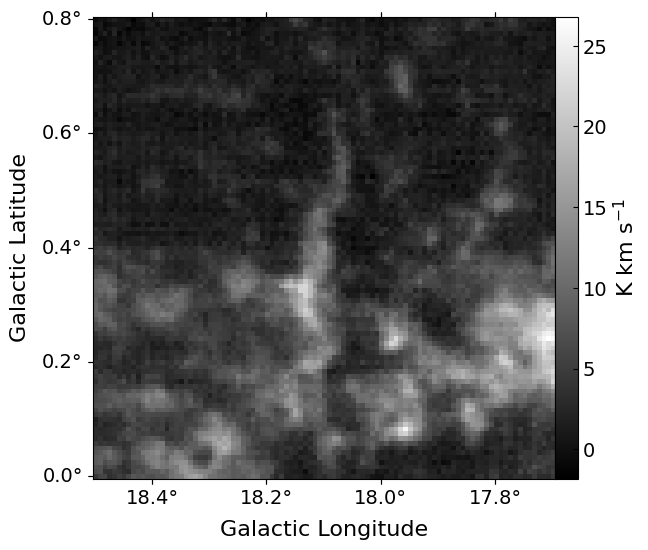

In [10]:
save_path = '../Images/Example_Data.pdf'
Plot_and_Save_Funs.Plot_Origin_Data(clumpsObj,figsize=(8,6),fontsize=16,spacing=12*u.arcmin,save_path=None)

Plot the detection results and save the image. 

The total number of clumps is 127, with 89 of them not touching the edge. The red asterisks denote the central position of the clumps, and the red lines denote the direction of the principal axis of the clumps.

In [11]:
edges = clumpsObj.edges
print('Total number:',len(edges))
print('NO edges number:',np.where(edges==0)[0].shape[0])

Total number: 126
NO edges number: 88


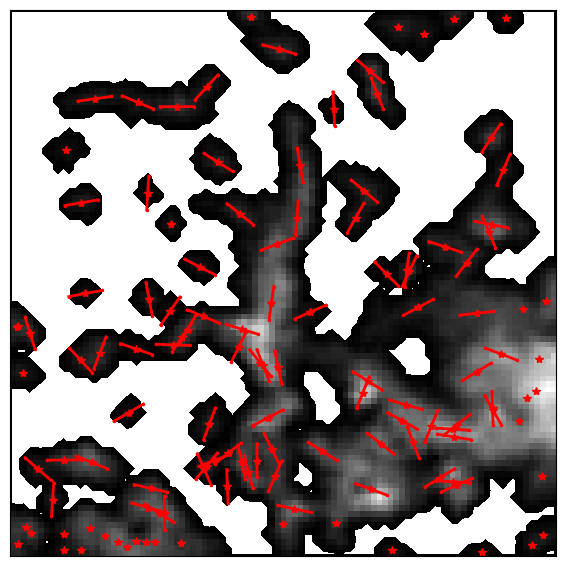

In [12]:
save_path = '../Images/Clumps_Infor.pdf'
Plot_and_Save_Funs.Plot_Clumps_Infor(clumpsObj,figsize=(8,6),line_scale=3,save_path=None)

Get the clumps information from the clumpsObj.

In [13]:
clump_angles = clumpsObj.angles
clump_edges = clumpsObj.edges
clump_centers = clumpsObj.centers
clump_centers_wcs = clumpsObj.centers_wcs
origin_data = clumpsObj.origin_data
regions_data = clumpsObj.regions_data
data_wcs = clumpsObj.data_wcs
connected_ids_dict = clumpsObj.connected_ids_dict
clump_coords_dict = clumpsObj.clump_coords_dict

clumps_data = np.zeros_like(origin_data)
clumps_data[regions_data>0] = origin_data[regions_data>0]

The morphology-based skeletonization method of DPConCFil is a highly effective technique for image skeletonization. It utilizes an iterative approach to progressively thin the binary image by evaluating pixel connectivity and topological features, enabling preservation or removal. In comparison to the medial axis-based skeletonization method of FilFinder, the morphology-based approach yields more prominent and notable skeleton structures. 

The morphology-based skeletonization method of DPConCFil has been removed from the paper.

In [14]:
filament_clumps_id = [64, 59, 60, 61, 62, 63]

filament_coords, filament_item, data_wcs_item, regions_data_T, start_coords, \
          filament_item_mask_2D, lb_area = FCFA.Filament_Coords(origin_data, \
          regions_data, data_wcs, clump_coords_dict, filament_clumps_id, CalSub=False)

fil_image = filament_item.sum(0)
fil_mask = filament_item.sum(0)>0
skeleton_coords_2D_Morphology,filament_skeleton,all_skeleton_coords = FCFA.Get_Single_Filament_Skeleton(fil_mask)

The original morphology skeleton extracted using the morphology-based skeletonization method of DPConCFil.

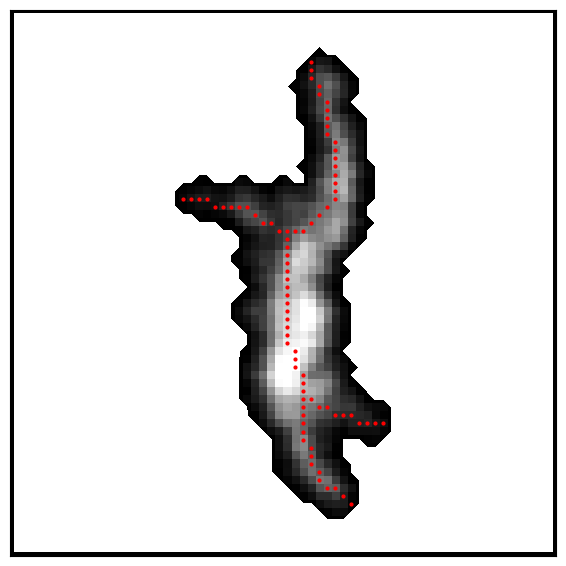

In [15]:
fig,(ax0)= plt.subplots(1,1, figsize=(8, 6))
skeleton_coords_2D = all_skeleton_coords
for i in range(len(skeleton_coords_2D)):
    ax0.plot(skeleton_coords_2D[i][1],skeleton_coords_2D[i][0],color='r',marker='.',markersize=4)
vmin, vmax = np.min(fil_image[np.where(fil_image!=0)]), np.nanpercentile(fil_image[np.where(fil_image!=0)], 98.)
ax0.imshow(fil_image,
           origin='lower',
           cmap='gray',
           interpolation='none',
           norm = colors.Normalize(vmin = vmin, vmax =  vmax))
ax0.contourf(fil_image,
             levels = [0., .01],
             colors = 'w')

fig.tight_layout()
plt.xticks([]),plt.yticks([])
# plt.savefig('Image/Filament_Skeleton_Morphology.png', format='png', dpi=1000)
plt.show()

### The Algorithm in the PP Space: FilFinder

In [16]:
from fil_finder import FilFinder2D

The original skeleton extracted from the mask of an example filament.

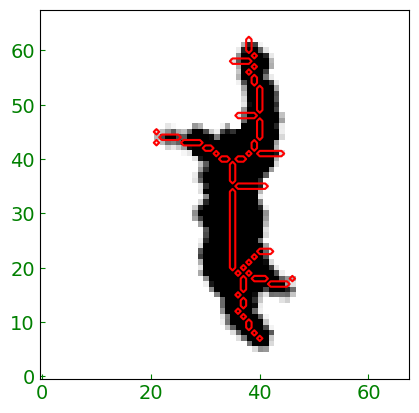

In [17]:
arr = fil_image
fil = FilFinder2D(arr)
fil.mask = fil_mask
fil.preprocess_image(skip_flatten=True)

fil.create_mask(use_existing_mask=True)
fil.medskel(verbose=True)

fil.analyze_skeletons(branch_thresh= 0 * u.pix, prune_criteria='length',skel_thresh=0*u.pix)
skeleton = fil.skeleton
skeleton_coords_FilFinder = np.c_[np.where(skeleton==1)[0],np.where(skeleton==1)[1]]

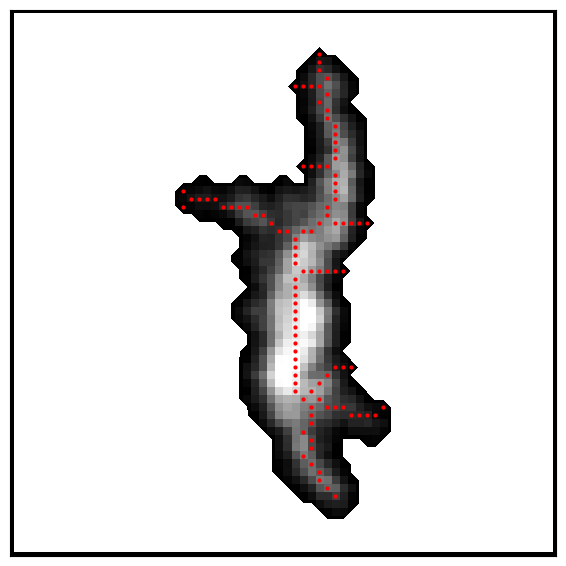

In [18]:
fig,(ax0)= plt.subplots(1,1, figsize=(8, 6))
skeleton_coords_2D = skeleton_coords_FilFinder
for i in range(len(skeleton_coords_2D)):
    ax0.plot(skeleton_coords_2D[i][1],skeleton_coords_2D[i][0],color='r',marker='.',markersize=4)
vmin, vmax = np.min(fil_image[np.where(fil_image!=0)]), np.nanpercentile(fil_image[np.where(fil_image!=0)], 98.)
ax0.imshow(fil_image,
           origin='lower',
           cmap='gray',
           interpolation='none',
           norm = colors.Normalize(vmin = vmin, vmax =  vmax))
ax0.contourf(fil_image,
             levels = [0., .01],
             colors = 'w')

fig.tight_layout()
plt.xticks([]),plt.yticks([])
# plt.savefig('Image/Filament_Skeleton_Morphology.png', format='png', dpi=1000)
plt.show()

The skeleton extracted from the mask of the integrated clumps.

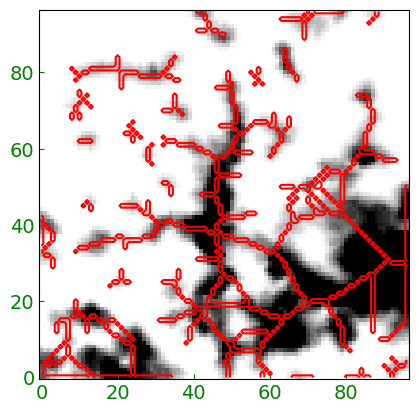

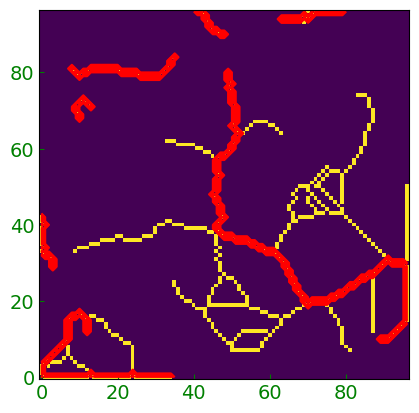

In [19]:
arr = (origin_data*(regions_data>0)).sum(0)
fil = FilFinder2D(arr)

mask = regions_data.sum(0) > 0
fil.mask = mask
fil.preprocess_image(skip_flatten=True)

fil.create_mask(use_existing_mask=True)
fil.medskel(verbose=True)

fil.analyze_skeletons(branch_thresh=10 * u.pix, prune_criteria='length',skel_thresh=10*u.pix)

plt.imshow(fil.skeleton, origin='lower')
plt.contour(fil.skeleton_longpath, colors='r')

In [20]:
img = np.array(fil.image)
mask = fil.mask
img = img*mask
img[img<0]=0
skeleton = fil.skeleton
skeleton_longpath = fil.skeleton_longpath

mask_label = measure.label(mask)
mask_regions = measure.regionprops(mask_label)
region_sizes = []
for region in mask_regions:
    region_sizes.append(len(region.coords))
mask_T = np.zeros_like(mask)
coords = mask_regions[np.argmax(region_sizes)].coords
mask_T[coords[:,0],coords[:,1]] = 1
skeleton_longpath_T = skeleton_longpath*mask_T

skeleton_coords = np.c_[np.where(skeleton==1)[0],np.where(skeleton==1)[1]]
skeleton_longpath_coords = np.c_[np.where(skeleton_longpath==1)[0],np.where(skeleton_longpath==1)[1]]

plt.style.use('default')

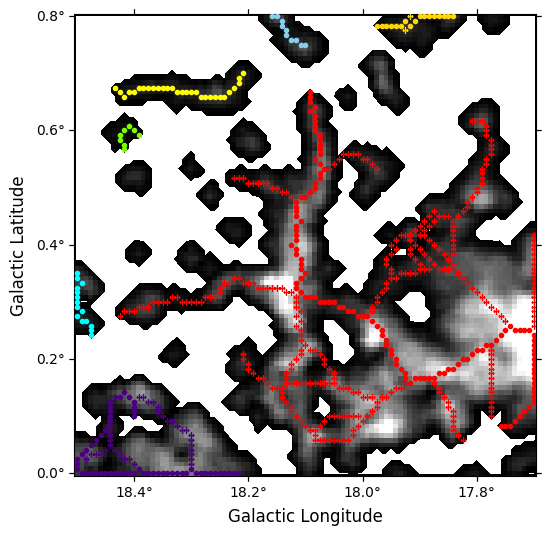

In [21]:
figsize=(8,6)
fontsize=12
spacing=12*u.arcmin
save_path='../Images/FilFinder_With_Mask.pdf'

fig = plt.figure(figsize=(8,6))
ax0 = fig.add_subplot(111,projection=data_wcs.celestial)

colors_T = ['indigo','red','cyan','lawngreen','yellow','gold','skyblue','orange','brown']


for branch_index in range(len(fil.filaments)):
    skeleton_coords = np.c_[fil.filaments[branch_index].pixel_coords[0],fil.filaments[branch_index].pixel_coords[1]]
    
    for i in range(len(skeleton_coords)):
        if skeleton_longpath[skeleton_coords[i][0],skeleton_coords[i][1]] == 1:
            ax0.plot(skeleton_coords[i][1],skeleton_coords[i][0],color=colors_T[branch_index],marker='.',lw=3, alpha=1.0, markersize=6)
        else:
            ax0.plot(skeleton_coords[i][1],skeleton_coords[i][0],color=colors_T[branch_index],marker='+',lw=3, alpha=1.0, markersize=4)

vmin = np.min(img[np.where(img!=0)])
vmax = np.nanpercentile(img[np.where(img!=0)], 98.)
ax0.imshow(img,
           origin='lower',
           cmap='gray',
           interpolation='none',
           norm = colors.Normalize(vmin = vmin, vmax =  vmax))
ax0.contourf(img,
             levels = [0., .01],
             colors = 'w')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.color'] = 'red'
plt.rcParams['ytick.color'] = 'red'
plt.xlabel("Galactic Longitude",fontsize=fontsize)
plt.ylabel("Galactic Latitude",fontsize=fontsize)
lon = ax0.coords[0]
lat = ax0.coords[1]
lon.set_major_formatter("d.d")
lat.set_major_formatter("d.d")
lon.set_ticks(spacing=spacing)
lat.set_ticks(spacing=spacing)
# plt.savefig(save_path, format='pdf', dpi=1000)
plt.show()

The skeleton extracted from the mask obtained by FilFinder on the velocity-integrated map.

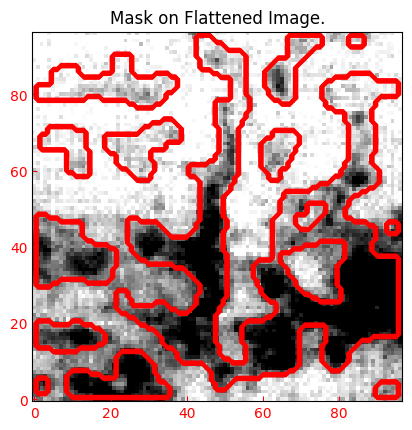

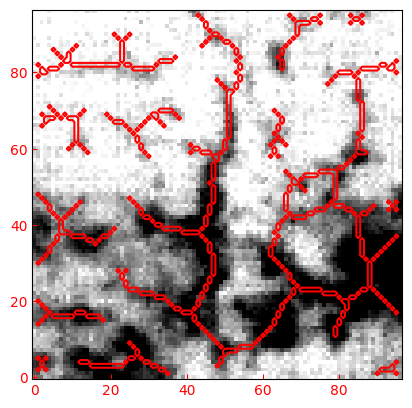

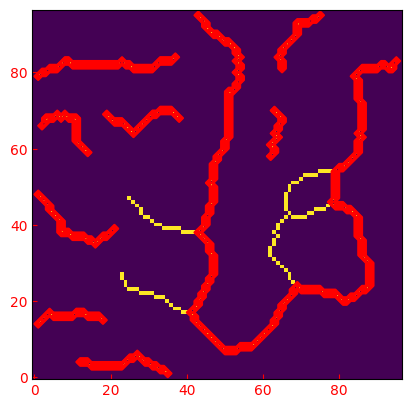

In [22]:
# HDU data as an array
arr = origin_data.sum(0)

fil = FilFinder2D(arr)

fil.preprocess_image(flatten_percent=95)


fil.create_mask(glob_thresh=5, adapt_thresh=3* u.pix,
                    smooth_size=1* u.pix, size_thresh=3* u.pix**2, verbose=True,
                    test_mode=False, regrid=True, border_masking=True,
                    border_kwargs={'size': 20 * u.pix**2,
                                   'filt_width': 1 * u.pix, 'eros_iter': 1},
                    fill_hole_size=16* u.pix**2,
                    use_existing_mask=False, save_png=False)

fil.medskel(verbose=True)

fil.analyze_skeletons(branch_thresh=10 * u.pix, prune_criteria='length',skel_thresh=10*u.pix)

plt.imshow(fil.skeleton, origin='lower')
plt.contour(fil.skeleton_longpath, colors='r')

In [23]:
img = np.array(fil.image)
mask = fil.mask
img = img*mask
img[img<0]=0
skeleton = fil.skeleton
skeleton_longpath = fil.skeleton_longpath

mask_label = measure.label(mask)
mask_regions = measure.regionprops(mask_label)
region_sizes = []
for region in mask_regions:
    region_sizes.append(len(region.coords))
mask_T = np.zeros_like(mask)
coords = mask_regions[np.argmax(region_sizes)].coords
mask_T[coords[:,0],coords[:,1]] = 1
skeleton_longpath_T = skeleton_longpath*mask_T

skeleton_coords = np.c_[np.where(skeleton==1)[0],np.where(skeleton==1)[1]]
skeleton_longpath_coords = np.c_[np.where(skeleton_longpath==1)[0],np.where(skeleton_longpath==1)[1]]

plt.style.use('default')

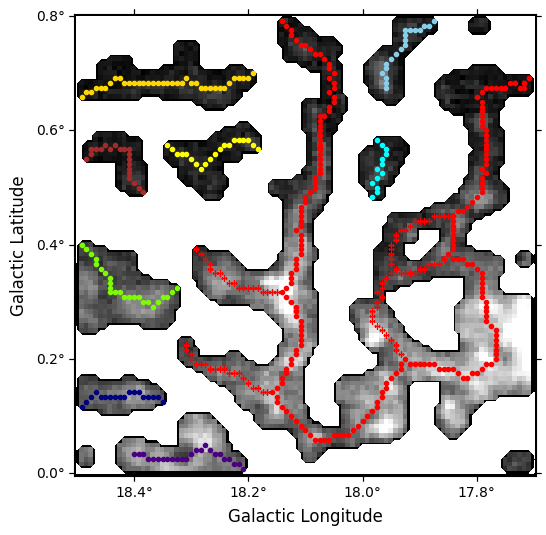

In [24]:
figsize=(8,6)
fontsize=12
spacing=12*u.arcmin
save_path='../Images/FilFinder_Without_Mask.pdf'

fig = plt.figure(figsize=(8,6))
ax0 = fig.add_subplot(111,projection=data_wcs.celestial)

colors_T = ['indigo','red','navy','lawngreen','yellow','cyan','brown','gold','skyblue']

for branch_index in range(len(fil.filaments)):
    skeleton_coords = np.c_[fil.filaments[branch_index].pixel_coords[0],fil.filaments[branch_index].pixel_coords[1]]
    
    for i in range(len(skeleton_coords)):
        if skeleton_longpath[skeleton_coords[i][0],skeleton_coords[i][1]] == 1:
            ax0.plot(skeleton_coords[i][1],skeleton_coords[i][0],color=colors_T[branch_index],marker='.',lw=3, alpha=1.0, markersize=6)
        else:
            ax0.plot(skeleton_coords[i][1],skeleton_coords[i][0],color=colors_T[branch_index],marker='+',lw=3, alpha=1.0, markersize=4)

vmin = np.min(img[np.where(img!=0)])
vmax = np.nanpercentile(img[np.where(img!=0)], 98.)
ax0.imshow(img,
           origin='lower',
           cmap='gray',
           interpolation='none',
           norm = colors.Normalize(vmin = vmin, vmax =  vmax))
ax0.contourf(img,
             levels = [0., .01],
             colors = 'w')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.color'] = 'red'
plt.rcParams['ytick.color'] = 'red'
plt.xlabel("Galactic Longitude",fontsize=fontsize)
plt.ylabel("Galactic Latitude",fontsize=fontsize)
lon = ax0.coords[0]
lat = ax0.coords[1]
lon.set_major_formatter("d.d")
lat.set_major_formatter("d.d")
lon.set_ticks(spacing=spacing)

# plt.savefig(save_path, format='pdf', dpi=1000)
plt.show()

### FilFinder in Simulation

In [15]:
RMS = 0.1
Threshold = 5 * RMS

parameters_FacetClumps = [RMS, Threshold, SWindow, KBins, FwhmBeam, VeloRes, SRecursionLBV]

In [23]:
file_name = 'RandA_260_13CO.fits'

file_example = 'Simulation_1'
mask_name = '../Example_Files/Clump/mask_{}.fits'.format(file_example)
outcat_name = '../Example_Files/Clump/outcat_{}.csv'.format(file_example)
outcat_wcs_name = '../Example_Files/Clump/outcat_wcs_{}.csv'.format(file_example)

In [17]:
clumpsObj = ClumpInfor(file_name,mask_name,outcat_name,outcat_wcs_name)

# clumpsObj.Cal_Infor_From_Mask_Or_Algorithm(mask_or_algorithm='FacetClumps',parameters=parameters_FacetClumps)
# clumpsObj.Get_Clumps_Infor(fit_flag = True)

clumpsObj.Cal_Infor_From_Mask_Or_Algorithm(mask_or_algorithm='mask')
clumpsObj.Get_Clumps_Infor(fit_flag = True)

Number: 373
Time: 0.46


100%|██████████| 373/373 [00:07<00:00, 49.07it/s]


Fitting Clumps Time: 7.88


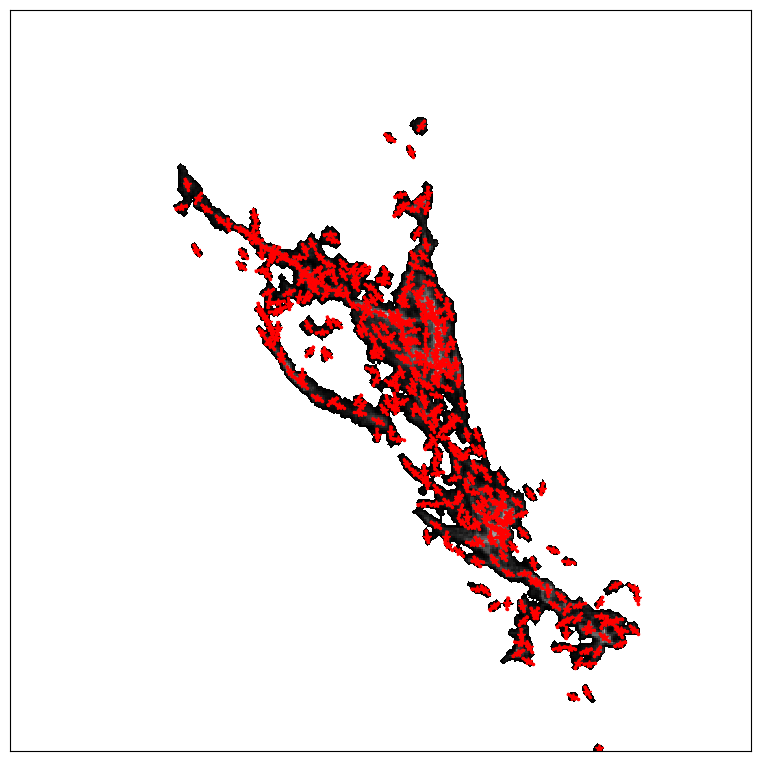

In [18]:
save_path = '../Images/Clumps_Infor.pdf'
Plot_and_Save_Funs.Plot_Clumps_Infor(clumpsObj,figsize=(12,8),line_scale=3,save_path=None)

In [19]:
clump_angles = clumpsObj.angles
clump_edges = clumpsObj.edges
clump_centers = clumpsObj.centers
clump_centers_wcs = clumpsObj.centers_wcs
origin_data = clumpsObj.origin_data
regions_data = clumpsObj.regions_data
data_wcs = clumpsObj.data_wcs
connected_ids_dict = clumpsObj.connected_ids_dict
clump_coords_dict = clumpsObj.clump_coords_dict

clumps_data = np.zeros_like(origin_data)
clumps_data[regions_data>0] = origin_data[regions_data>0]

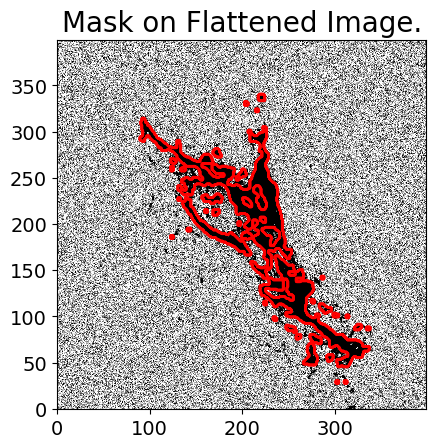

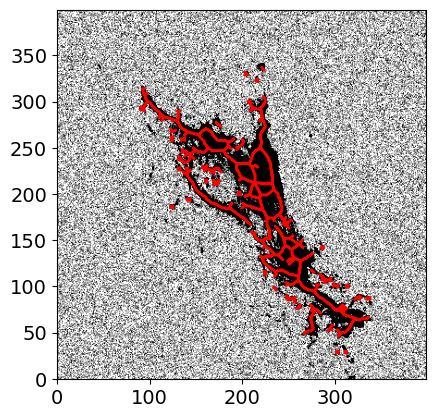

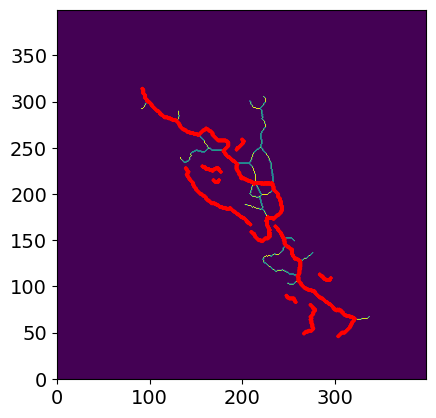

In [20]:
# HDU data as an array
arr = origin_data.sum(0)

fil = FilFinder2D(arr)

fil.preprocess_image(flatten_percent=95)


fil.create_mask(glob_thresh=5/2.2, adapt_thresh=3* u.pix,
                    smooth_size=1* u.pix, size_thresh=3* u.pix**2, verbose=True,
                    test_mode=False, regrid=True, border_masking=True,
                    border_kwargs={'size': 20 * u.pix**2,
                                   'filt_width': 1 * u.pix, 'eros_iter': 1},
                    fill_hole_size=16* u.pix**2,
                    use_existing_mask=False, save_png=False)

fil.medskel(verbose=True)

fil.analyze_skeletons(branch_thresh=10 * u.pix, prune_criteria='length',skel_thresh=10*u.pix)

plt.imshow(fil.skeleton, origin='lower')
plt.contour(fil.skeleton_longpath, colors='r')

In [21]:
img = np.array(fil.image)
mask = fil.mask
img = img*mask
img[img<0]=0
skeleton = fil.skeleton
skeleton_longpath = fil.skeleton_longpath

mask_label = measure.label(mask)
mask_regions = measure.regionprops(mask_label)
region_sizes = []
for region in mask_regions:
    region_sizes.append(len(region.coords))
mask_T = np.zeros_like(mask)
coords = mask_regions[np.argmax(region_sizes)].coords
mask_T[coords[:,0],coords[:,1]] = 1
skeleton_longpath_T = skeleton_longpath*mask_T

skeleton_coords = np.c_[np.where(skeleton==1)[0],np.where(skeleton==1)[1]]
skeleton_longpath_coords = np.c_[np.where(skeleton_longpath==1)[0],np.where(skeleton_longpath==1)[1]]

plt.style.use('default')

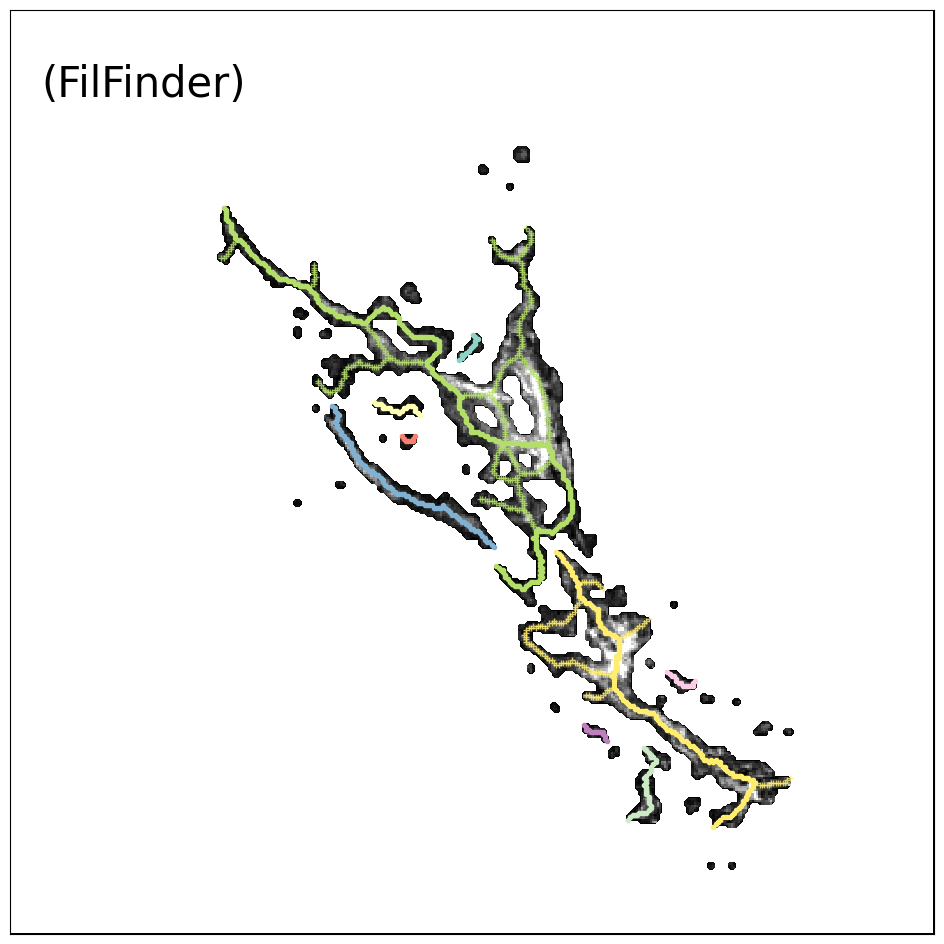

In [22]:
fontsize = 30
fig = plt.figure(figsize=(14,12))
ax0 = fig.add_subplot(111)#,projection=data_wcs.celestial)

colors_T = plt.cm.Set3(np.linspace(0, 1, len(fil.filaments)))
colors_T = colors_T[::-1]
for branch_index in range(len(fil.filaments)):
    skeleton_coords = np.c_[fil.filaments[branch_index].pixel_coords[0],fil.filaments[branch_index].pixel_coords[1]]
    for i in range(len(skeleton_coords)):
        if skeleton_longpath[skeleton_coords[i][0],skeleton_coords[i][1]] == 1:
            ax0.plot(skeleton_coords[i][1],skeleton_coords[i][0],color=colors_T[branch_index],marker='.',lw=3, alpha=1.0, markersize=6)
        else:
            ax0.plot(skeleton_coords[i][1],skeleton_coords[i][0],color=colors_T[branch_index],marker='+',lw=2, alpha=0.8, markersize=4)
ax0.text(13,362,r'({})'.format('FilFinder'),color='black',fontsize=fontsize)
vmin = np.min(img[np.where(img!=0)])
vmax = np.nanpercentile(img[np.where(img!=0)], 98.)
ax0.imshow(img,
           origin='lower',
           cmap='gray',
           interpolation='none',
           norm = colors.Normalize(vmin = vmin, vmax =  vmax))
ax0.contourf(img,
             levels = [0., .01],
             colors = 'w')
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.color'] = 'red'
plt.rcParams['ytick.color'] = 'red'
# plt.xlabel("Galactic Longitude",fontsize=fontsize)
# plt.ylabel("Galactic Latitude",fontsize=fontsize)

plt.xticks([]),plt.yticks([])

# plt.savefig('../Images/HD_FilFinder.pdf', format='pdf', dpi=1000)
plt.show()